#### Import Libraries

In [88]:
import pandas as pd
import yaml
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np

#### Helper Functions

In [89]:
def load_config():
    with open("config.yml", 'r') as file:
        return yaml.safe_load(file)

In [90]:
def create_db_engine(db_config):
    db_url = f"postgresql+psycopg2://{db_config['uid']}:{db_config['pwd']}@{db_config['server']}:{db_config['port']}/{db_config['database']}"
    return create_engine(db_url)

In [91]:
def load_data(engine, query):
    with engine.connect() as connection:
        return pd.read_sql(query, connection)

In [92]:
def aggregate_columns(df, aggregation_map):
    for new_col, cols_to_sum in aggregation_map.items():
        df[cols_to_sum] = df[cols_to_sum].apply(pd.to_numeric, errors='coerce').fillna(0)
        df[new_col] = df[cols_to_sum].sum(axis=1)
    return df

In [93]:
def calculate_exclusion_ratio(df, suspension_cols, enrollment_col, new_col_name, missing_data_value=None):
    """
    Calculates the ratio of disciplinary actions to total enrollment for given columns.

    Parameters:
    - df: DataFrame to operate on.
    - suspension_cols: List of columns representing counts of disciplinary actions.
    - enrollment_col: Column name for enrollment data.
    - new_col_name: Name of the new column for the calculated ratio.
    - missing_data_value: Value to assign if calculation cannot be performed.

    Returns:
    - Modified DataFrame with the new ratio column.
    """

    df = df.copy()

    df.loc[:, suspension_cols] = df[suspension_cols].apply(pd.to_numeric, errors='coerce')
    df.loc[:, enrollment_col] = pd.to_numeric(df[enrollment_col], errors='coerce')

    df[new_col_name] = missing_data_value

    for idx, row in df.iterrows():
        if pd.isnull(row[enrollment_col]) or row[enrollment_col] <= 0:
            df.loc[idx, new_col_name] = missing_data_value
        else:
            disciplinary_action_count = row[suspension_cols].sum(skipna=True)
            df.loc[idx, new_col_name] = disciplinary_action_count / row[enrollment_col]

    return df

In [94]:
def calculate_violent_inc_ratio(df, numerator_cols, enrollment_col, new_col_name, missing_data_value=None):
    """
    Calculates the ratio of violent incidents to total enrollment for given columns.
    
    Parameters:
    - df: DataFrame to operate on.
    - numerator_cols: List of columns representing counts of violent incidents.
    - enrollment_col: Column name for enrollment data.
    - new_col_name: Name of the new column for the calculated ratio.
    - missing_data_value: Value to assign if calculation cannot be performed.

    Returns:
    - Modified DataFrame with the new ratio column.
    """

    df = df.copy()

    df.loc[:, numerator_cols] = df[numerator_cols].apply(pd.to_numeric, errors='coerce')
    df.loc[:, enrollment_col] = pd.to_numeric(df[enrollment_col], errors='coerce')

    df[new_col_name] = missing_data_value

    for idx, row in df.iterrows():
        if pd.isnull(row[enrollment_col]) or row[enrollment_col] <= 0:
            df.loc[idx, new_col_name] = missing_data_value
        else:
            violence_incidents_count = row[numerator_cols].sum(skipna=True)
            df.loc[idx, new_col_name] = violence_incidents_count / row[enrollment_col]

    return df

In [95]:
def count_schools_by_quantile(df, column, quantiles, column_label="quantile"):
    """
    Calculates the number of schools in each quantile for a given column using
    precomputed quantiles.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        column (str): The column for which quantile counts are calculated.
        quantiles (Series): Precomputed quantile values.
        column_label (str): The name of the new column to store quantile labels.

    Returns:
        DataFrame: A DataFrame with quantile ranges and counts.
    """

    quantile_labels = [f"Q{i+1}" for i in range(len(quantiles) - 1)]

    df[column] = pd.to_numeric(df[column], errors='coerce')
    df = df.dropna(subset=[column])
    
    df[column_label] = pd.cut(df[column], bins=quantiles, labels=quantile_labels, include_lowest=True)

    quantile_counts = df.groupby(column_label, observed=False).size().reset_index(name="school_count")

    quantile_ranges = [f"[{quantiles[i]:.2f}, {quantiles[i+1]:.2f}]" for i in range(len(quantiles))]

    quantile_summary = pd.DataFrame({
        "quantile": quantile_labels,
        "quantile_range": quantile_ranges,
        "school_count": quantile_counts["school_count"].values
    })
    
    return quantile_summary

In [96]:
def generate_histograms(report_card_df, rssi_schools_df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle('Histograms for Disciplinary Action and Violent Incidents Ratios', fontsize=16)

    # All Schools: Disciplinary Action Ratio
    axes[0, 0].hist(
        report_card_df['disciplinary_action_ratio'].dropna(), bins=10,
        color='blue', edgecolor='black', alpha=0.7
    )
    axes[0, 0].set_title("All Schools - Disciplinary Action Ratio")
    axes[0, 0].set_xlabel("Ratio")
    axes[0, 0].set_ylabel("Frequency")
    axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # All Schools: Violent Incidents Ratio
    axes[0, 1].hist(
        report_card_df['violent_incidents_ratio'].dropna(), bins=10, color='red',
        edgecolor='black', alpha=0.7
    )
    axes[0, 1].set_title("All Schools - Violent Incidents Ratio")
    axes[0, 1].set_xlabel("Ratio")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

    # RSSI Schools: Disciplinary Action Ratio
    axes[1, 0].hist(
        rssi_schools_df['disciplinary_action_ratio'].dropna(), bins=10,
        color='green', edgecolor='black', alpha=0.7
    )
    axes[1, 0].set_title("RSSI Schools - Disciplinary Action Ratio")
    axes[1, 0].set_xlabel("Ratio")
    axes[1, 0].set_ylabel("Frequency")
    axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # RSSI Schools: Violent Incidents Ratio
    axes[1, 1].hist(
        rssi_schools_df['violent_incidents_ratio'].dropna(), bins=10, color='purple',
        edgecolor='black', alpha=0.7
    )
    axes[1, 1].set_title("RSSI Schools - Violent Incidents Ratio")
    axes[1, 1].set_xlabel("Ratio")
    axes[1, 1].set_ylabel("Frequency")
    axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


#### Load the configuration and establish the database connection

In [97]:
config = load_config()
db_config = config['rssi-data-warehouse']['dataconnection']
engine = create_db_engine(db_config)

#### Define the queries and load the data

In [98]:
report_card_query = """
SELECT rcdts, num_stdnt_enrlmnt
FROM report_card
"""

report_card_disc_query = """
SELECT rcdts, isbe_type, school_name, district, 
    num_stdnts_with_discipline_incidents,
    num_disc_incdts_viol_harm, num_disc_incdts_viol_noharm, 
    num_disc_incdts_firearm, num_disc_incdts_oth_wpn
FROM report_card_disc
"""

rssi_cohorts_query = """
SELECT rcdts
FROM rssi_cohorts
"""

report_card_df = load_data(engine, report_card_query)
report_card_disc_df = load_data(engine, report_card_disc_query)
rssi_cohorts_df = load_data(engine, rssi_cohorts_query)

#### Merge dataframes & aggregate columns

In [101]:
report_card_df = pd.merge(report_card_df, report_card_disc_df, on='rcdts', how='inner')

aggregation_map_disc = {
    'num_disc_incdts_violent': [
        'num_disc_incdts_viol_harm', 'num_disc_incdts_viol_noharm'
    ],
    'num_disc_incdts_other': [
        'num_disc_incdts_firearm', 'num_disc_incdts_oth_wpn'
    ]
}
report_card_df = aggregate_columns(report_card_df, aggregation_map_disc)

#### Calculate and describe ratios

In [102]:
report_card_df = calculate_exclusion_ratio(
    report_card_df, ['num_stdnts_with_discipline_incidents'], 
    'num_stdnt_enrlmnt', 'disciplinary_action_ratio'
)

report_card_df = calculate_violent_inc_ratio(
    report_card_df, ['num_disc_incdts_violent', 'num_disc_incdts_other'], 
    'num_stdnts_with_discipline_incidents', 'violent_incidents_ratio'
)

report_card_df['disciplinary_action_ratio'] = pd.to_numeric(report_card_df['disciplinary_action_ratio'], errors='coerce')
report_card_df['violent_incidents_ratio'] = pd.to_numeric(report_card_df['violent_incidents_ratio'], errors='coerce')
report_card_df[['disciplinary_action_ratio', 'violent_incidents_ratio']].describe().round(2)

,disciplinary_action_ratio,violent_incidents_ratio
count,18781.00,15650.00
mean,0.05,0.59
std,0.07,0.58
min,0.00,0.00
25%,0.01,0.12
50%,0.03,0.50
75%,0.07,0.93
max,0.77,6.00


The data reveals that, on average, the **disciplinary action ratio** across the 18,781 schools is relatively low, with a mean of 0.05 and a standard deviation of 0.07. This suggests that most schools have a small proportion of students involved in disciplinary actions. The distribution of this ratio is skewed, with the 25th percentile at 0.01 and the 75th percentile at 0.07, indicating that the majority of schools report minimal disciplinary incidents. However, the maximum value of 0.77 suggests that there are a small number of schools experiencing significantly higher disciplinary actions, creating a considerable spread in the data.

In contrast, the **violent incidents ratio** has a much higher mean of 0.59 and a similar standard deviation of 0.58, indicating greater variability in the frequency of violent incidents. The data is more spread out, with the 25th percentile at 0.12 and the 75th percentile at 0.93, implying that many schools report a relatively small number of violent incidents, but a significant proportion of schools experience much higher rates. The maximum value of 6.00, a considerable outlier, suggests that there are a few schools with exceptionally high rates of violent incidents. This highlights that while violent incidents may be rare in many schools, a small number of schools have disproportionately high occurrences.

Filter RSSI schools

In [104]:
rssi_rcdts = rssi_cohorts_df['rcdts']
rssi_schools_df = report_card_df[report_card_df['rcdts'].isin(rssi_rcdts)]

rssi_schools_df = calculate_exclusion_ratio(
    rssi_schools_df, ['num_stdnts_with_discipline_incidents'], 
    'num_stdnt_enrlmnt', 'disciplinary_action_ratio'
)

rssi_schools_df = calculate_violent_inc_ratio(
    rssi_schools_df, ['num_disc_incdts_violent', 'num_disc_incdts_other'], 
    'num_stdnts_with_discipline_incidents', 'violent_incidents_ratio'
)

rssi_schools_df['disciplinary_action_ratio'] = pd.to_numeric(rssi_schools_df['disciplinary_action_ratio'], errors='coerce')
rssi_schools_df['violent_incidents_ratio'] = pd.to_numeric(rssi_schools_df['violent_incidents_ratio'], errors='coerce')
rssi_schools_df[['disciplinary_action_ratio', 'violent_incidents_ratio']].describe().round(2)

,disciplinary_action_ratio,violent_incidents_ratio
count,1377.00,1213.00
mean,0.06,0.55
std,0.07,0.56
min,0.00,0.00
25%,0.01,0.08
50%,0.04,0.45
75%,0.08,0.86
max,0.64,4.65


When analyzing the **RSSI schools** subset, we observe some similarities and differences compared to the overall school population. The **disciplinary action ratio** for RSSI schools has a mean of 0.06 and a standard deviation of 0.07, which is slightly higher than the mean for all schools (0.05). The spread of this ratio in RSSI schools is comparable to all schools, with the 25th percentile at 0.01 and the 75th percentile at 0.08, showing that most RSSI schools also report low disciplinary incidents. However, the maximum value for RSSI schools is 0.64, which is lower than the maximum of 0.77 observed for all schools, indicating fewer extreme cases in this subset.

For **violent incidents**, the mean for RSSI schools is 0.55, slightly lower than the 0.59 observed for all schools, with a standard deviation of 0.56. The spread of this ratio in RSSI schools is also noticeable: the 25th percentile is at 0.08, and the 75th percentile is at 0.86, which indicates a higher concentration of schools with violent incident ratios closer to the higher end of the distribution, compared to all schools. The maximum value of 4.65, while lower than the all-schools maximum of 6.00, still represents a significant outlier, showing that while most RSSI schools report low rates of violent incidents, a subset has notably higher rates. The distribution of violent incidents in RSSI schools appears slightly more skewed than that for all schools.

#### Quantile calculations

In [105]:
all_schools_disciplinary_quantiles = report_card_df['disciplinary_action_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
all_schools_violent_quantiles = report_card_df['violent_incidents_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

rssi_disciplinary_quantiles = rssi_schools_df['disciplinary_action_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])
rssi_violent_quantiles = rssi_schools_df['violent_incidents_ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

#### Create quantiles table

In [106]:
columns = pd.MultiIndex.from_product(
    [['Disciplinary Action Ratio', 'Violent Incidents Ratio'],
    ['All Schools', 'RSSI Schools'],],
    names=['School Type', 'Metric']
)

quantiles_table = pd.DataFrame(
    data=np.array([
        all_schools_disciplinary_quantiles.values,
        rssi_disciplinary_quantiles.values,
        all_schools_violent_quantiles.values,
        rssi_violent_quantiles.values
        
    ]).T,
    columns=columns,
    index=all_schools_disciplinary_quantiles.index
)

quantiles_table.index.name = 'Quantile'

display(quantiles_table)

School Type Disciplinary Action Ratio              Violent Incidents Ratio  \
Metric                    All Schools RSSI Schools             All Schools   
Quantile                                                                     
0.0                          0.000000     0.000000                0.000000   
0.2                          0.003210     0.007018                0.051282   
0.4                          0.018272     0.025275                0.333333   
0.6                          0.042662     0.048721                0.638979   
0.8                          0.088468     0.100138                1.000000   
1.0                          0.766571     0.638889                6.000000   

School Type               
Metric      RSSI Schools  
Quantile                  
0.0             0.000000  
0.2             0.021277  
0.4             0.285714  
0.6             0.578947  
0.8             1.000000  
1.0             4.647059

For the **disciplinary action ratio**, both groups show low median values (0.018 for all schools and 0.025 for RSSI schools), indicating that the majority of schools have relatively low disciplinary actions. However, the 80th and 100th percentiles for all schools are slightly higher than those for RSSI schools, suggesting that a subset of all schools exhibits more extreme ratios of disciplinary actions compared to RSSI schools.

In terms of the **violent incidents ratio**, the data indicates greater variability. The median ratio for all schools (0.333) is higher than for RSSI schools (0.286), showing that violent incidents are somewhat more common in all schools. However, the maximum ratio for all schools (6.0) exceeds that of RSSI schools (4.65), suggesting that extreme cases of violence are more frequent in the broader school population. Both distributions are skewed, as evidenced by higher values in the upper quantiles, but RSSI schools exhibit less extreme outliers. These findings may indicate differing behavioral trends or reporting practices between the two groups.

#### Create histograms

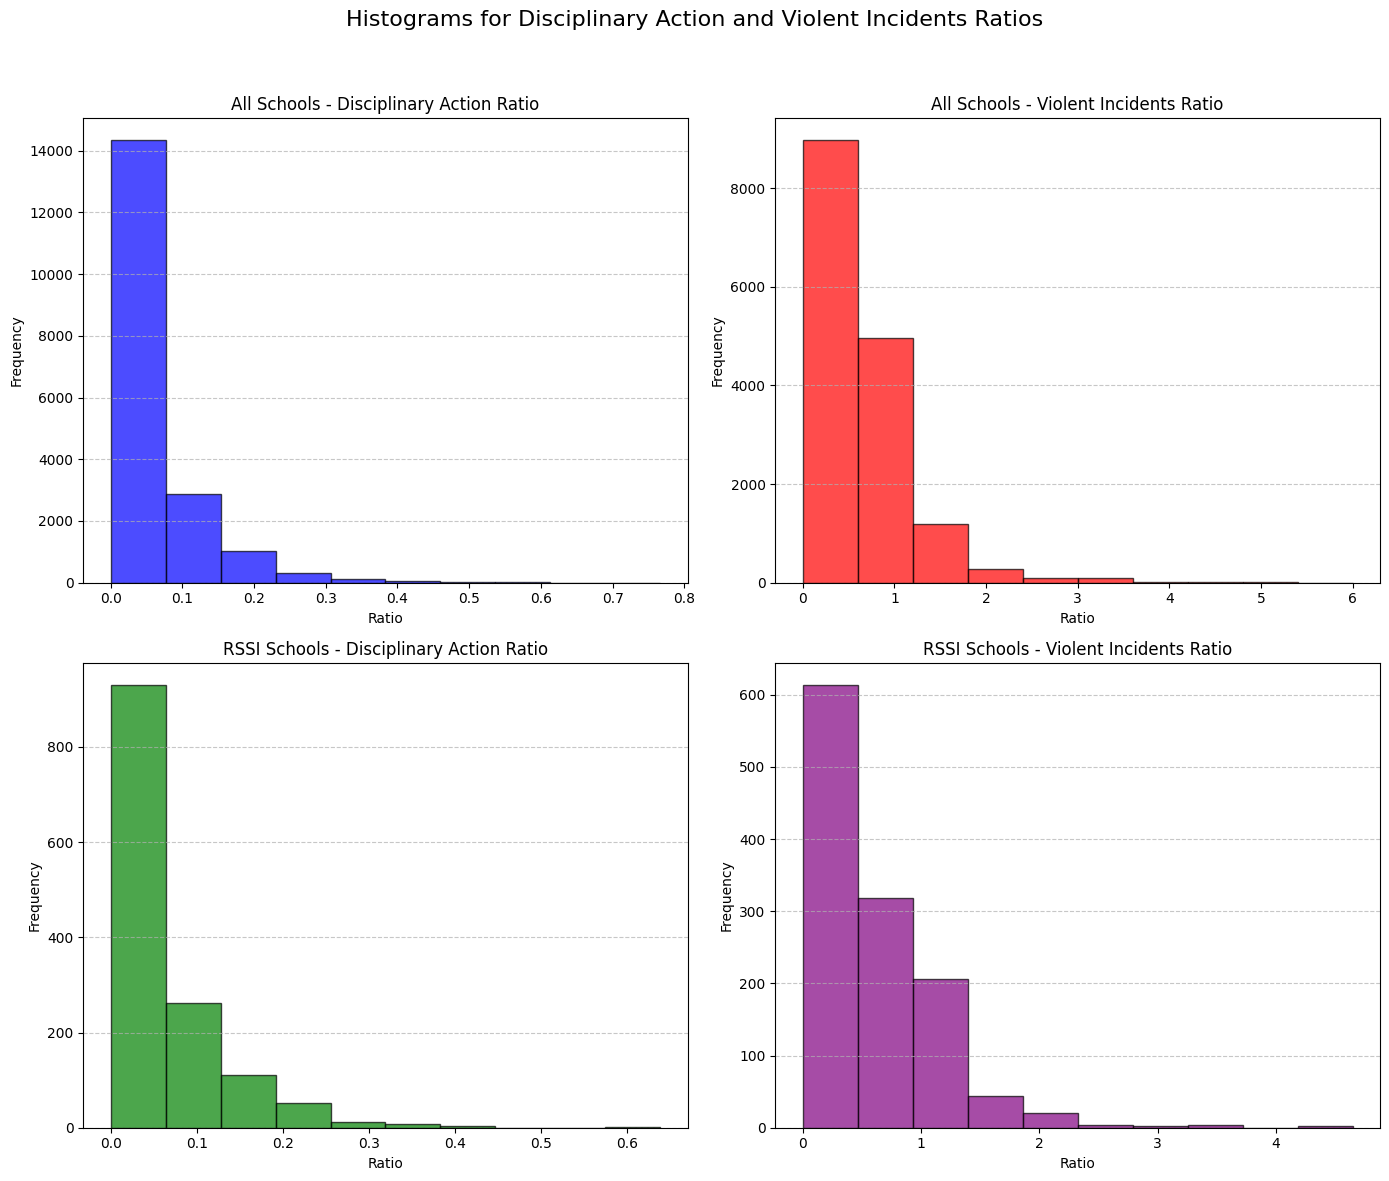

In [107]:
generate_histograms(report_card_df, rssi_schools_df)

In [112]:
def normalize_scores(df, column):
    df[column + '_log'] = np.log1p(df[column])

    max_log = df[column + '_log'].max()
    min_log = df[column + '_log'].min()
    
    df[column + '_score'] = 100 * (1 - (df[column + '_log'] - min_log) / (max_log - min_log))
    return df

def granular_rescale(df, column):

    df[column + '_log'] = np.log1p(df[column])

    low_threshold = df[column + '_log'].quantile(0.25)  # 25th percentile (low range)
    high_threshold = df[column + '_log'].quantile(0.75)  # 75th percentile (high range)
    
    def rescale_low(x):
        # For values below the 25th percentile, use a steeper scaling
        return 100 * (1 - (x - low_threshold) / (high_threshold - low_threshold))
    
    def rescale_mid(x):
        # For values between the 25th and 75th percentile, use a linear scale
        return 100 * (1 - (x - low_threshold) / (high_threshold - low_threshold))

    def rescale_high(x):
        # For values above the 75th percentile, use a more gradual scaling
        return 100 * (1 - np.log1p(x - high_threshold) / (np.log1p(df[column + '_log'].max() - high_threshold)))

    df[column + '_score_granular'] = df[column + '_log'].apply(lambda x: rescale_low(x) if x <= low_threshold
                                                              else rescale_mid(x) if x <= high_threshold
                                                              else rescale_high(x))
    
    return df

def custom_score(df, column):
    bins = [0, 0.01, 0.05, 0.1, 0.2, 0.5, float('inf')]
    scores = [100, 80, 60, 40, 20, 10]
    
    df[column + '_score_custom'] = pd.cut(df[column], bins=bins, labels=scores, right=False)
    df = df.dropna(subset=[column + '_score_custom'])
    df[column + '_score_custom'] = df[column + '_score_custom'].astype(int)
    
    return df

report_card_df = normalize_scores(report_card_df, 'disciplinary_action_ratio')
report_card_df = normalize_scores(report_card_df, 'violent_incidents_ratio')

report_card_df = custom_score(report_card_df, 'disciplinary_action_ratio')
report_card_df = custom_score(report_card_df, 'violent_incidents_ratio')

report_card_df = granular_rescale(report_card_df, 'disciplinary_action_ratio')
report_card_df = granular_rescale(report_card_df, 'violent_incidents_ratio')


report_card_df[[
    'disciplinary_action_ratio_score',
    'disciplinary_action_ratio_score_granular',
    'violent_incidents_ratio_score',
    'violent_incidents_ratio_score_granular'
]].describe().round(2)


,disciplinary_action_ratio_score,disciplinary_action_ratio_score_granular,violent_incidents_ratio_score,violent_incidents_ratio_score_granular
count,15650.00,15650.00,15650.00,15650.00
mean,89.53,79.14,79.03,74.86
std,11.19,30.33,16.54,35.83
min,0.00,0.00,0.00,0.00
25%,85.73,60.72,66.12,46.87
50%,93.20,86.33,79.16,80.54
75%,97.29,100.00,93.95,100.00
max,100.00,123.43,100.00,121.75


### Granular Rescaling for Skewed Distribution of Ratios

The goal of this approach is to fine-tune the scoring of two heavily skewed ratio metrics (`disciplinary_action_ratio` and `violent_incidents_ratio`) to better represent the distribution of these variables. The ratios are often characterized by a heavy concentration of values in the lower ranges, which makes traditional linear scoring inadequate in capturing subtle differences in the lower and higher ends of the distribution. 

The updated approach utilizes several techniques to improve the granularity and fairness of the scores:

1. **Log Transformation (`log1p`)**:
   - The `log1p` function is applied to both ratios to compress the upper tail and make the distribution more symmetric. This helps reduce the skewness, especially for outliers in the higher range.
   
2. **Granular Rescaling**:
   - **Low range (below 25th percentile)**: A steep linear scaling is used to better differentiate between values in this region, which typically contain more observations.
   - **Mid range (between 25th and 75th percentiles)**: A linear rescaling approach is employed here to provide a moderate adjustment to scores.
   - **High range (above 75th percentile)**: A more gradual scaling (based on a logarithmic adjustment) is used to prevent the scores from expanding too rapidly, as outliers in this region are less common.

3. **Custom Scoring**:
   - For comparison, a custom binning approach divides the data into predefined ranges (e.g., `0.01`, `0.05`, etc.) and assigns scores based on these ranges. This method provides a categorical distinction between different levels of the ratio.

### Current Limitations:
While this approach improves the representation of values across different segments of the distribution, there are still a few limitations:
- **Outlier Handling**: Even though the logarithmic and granular transformations help, extreme outliers may still affect the scoring, especially in the higher ranges. The scaling doesn't fully normalize these extreme values.
- **Interpretability**: For users unfamiliar with the transformation or the custom scoring bins, it might be difficult to interpret what the raw scores mean in the context of the original data.
- **Dependence on Quantiles**: The rescaling depends on the quantiles (25th and 75th percentiles), which might not always be the most effective thresholds, especially if the data distribution is highly uneven or has unusual peaks.
- **Performance**: For very large datasets, applying these transformations across many columns and ratios might require optimization to ensure quick computations. 

The scoring results for both `disciplinary_action_ratio` and `violent_incidents_ratio` demonstrate the differences between the two scoring approaches: **standard scoring** and **granular rescaling**.

#### **Disciplinary Action Ratio Scores**:
- **Standard Scoring**: The mean score is 89.53, indicating that most schools fall on the higher end of the scale. The distribution is fairly concentrated around the upper range, with the 25th percentile at 85.73 and the 75th percentile at 97.29. The relatively low standard deviation (11.19) suggests that the scores are fairly consistent across the dataset.
- **Granular Rescaling**: The granular rescaling method, however, yields a mean of 79.14 and a higher standard deviation of 30.33. This approach creates more variation in the scores, with the 25th percentile at 60.72 and the 75th percentile reaching 100. This indicates that the granular scaling accounts for more variability, especially by increasing the scores of higher values more significantly.

#### **Violent Incidents Ratio Scores**:
- **Standard Scoring**: The violent incidents ratio shows a slightly lower mean of 79.03, with a similar distribution to the disciplinary action ratio. The standard deviation (16.54) is larger than the disciplinary action ratio’s, reflecting a greater spread of values. The 25th percentile is 66.12, and the 75th percentile is 93.95, suggesting a moderate concentration around the upper-middle range.
- **Granular Rescaling**: The granular score for violent incidents ratio shows a mean of 74.86 and a larger standard deviation of 35.83. Like the disciplinary action ratio, this approach introduces more spread, with a 25th percentile of 46.87 and a 75th percentile reaching 100. This demonstrates how the granular rescaling method adjusts for a wider range of values, particularly for the lower and mid-range values.
